# Regression on Sydney House Price Dataset

[Sydney Housing Dataset](https://www.kaggle.com/shree1992/housedata) contains info about housing prices in different cities of USA. And describe them by different attributes like size, city, floors, bathrooms, condition etc. The main aim of the project is to evaluate 4 different type of linear regression algorithms. In this exercise, we'll merely focus on three classification algorithms 
1. Linear Regression (Ordinary Least Square without any Regularization)
1. Ridge Regression
2. Lasso Regression
3. Elastic Net Regression

And to keep things simple, Coefficient of Determination i.e. R-2 is used as evaluation metric. The date and street column provide no useful info so we dropped them for simplicity.

This exercise is a part of Homework 2 of open source [applied ML course taught by Andreas Mueller](https://www.cs.columbia.edu/~amueller/comsw4995s20/schedule/).

In [406]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector, TransformedTargetRegressor
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score

## Investigating the Dataset (Preprocessing)

In [363]:
file_path = r'housedata/data.csv'
df_raw = pd.read_csv(file_path)

In [364]:
df = df_raw.copy()
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [365]:
# To keep things simple, we can ignore date and street column bcz they will only make it hard while categorial encoding
del df['street'], df['date']

In [366]:
df.info() # no empty values so  seems good 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4600 non-null   float64
 1   bedrooms       4600 non-null   float64
 2   bathrooms      4600 non-null   float64
 3   sqft_living    4600 non-null   int64  
 4   sqft_lot       4600 non-null   int64  
 5   floors         4600 non-null   float64
 6   waterfront     4600 non-null   int64  
 7   view           4600 non-null   int64  
 8   condition      4600 non-null   int64  
 9   sqft_above     4600 non-null   int64  
 10  sqft_basement  4600 non-null   int64  
 11  yr_built       4600 non-null   int64  
 12  yr_renovated   4600 non-null   int64  
 13  city           4600 non-null   object 
 14  statezip       4600 non-null   object 
 15  country        4600 non-null   object 
dtypes: float64(4), int64(9), object(3)
memory usage: 575.1+ KB


### 2.1 Determine which features are continuous vs categorical. Drop rows without a valid sales price.

In [368]:
df.describe() # minimum price of zero suggest we should look into dataset closely

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,808.608261
std,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,979.414536
min,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000
50%,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000
75%,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,1999.000000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000


In [369]:
df[df['price']==0].count()[0] # total 49 values are zero so we have to do something of them

49

In [371]:
# lets delete them
df = df[df['price']!=0]
df.describe() # minimum value of price has increased from zero as expected

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4.551000e+03,4551.000000,4551.000000,4551.000000,4.551000e+03,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000
mean,5.579059e+05,3.394639,2.155021,2132.372226,1.483528e+04,1.512195,0.006592,0.234674,3.449352,1822.221710,310.150516,1970.795649,808.564052
std,5.639299e+05,0.904595,0.776351,955.949708,3.596408e+04,0.538531,0.080932,0.765373,0.675160,854.452888,461.987629,29.760073,979.421487
min,7.800000e+03,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,3.262643e+05,3.000000,1.750000,1460.000000,5.000000e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000
50%,4.650000e+05,3.000000,2.250000,1970.000000,7.680000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000
75%,6.575000e+05,4.000000,2.500000,2610.000000,1.097800e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,600.000000,1997.000000,1999.000000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000


In [372]:
df_targets_handled = df.copy() #  for future use

### Comment
using .isna() method on dataframe told us that there are no empty values in the dataset. However, examining closely the dataset, we found that in the last entries some price values are encoded as zero that isn't possible. So, we have to get rid of them.

Moreover, instead of filling with a constant value say mean, median it makes more sense to just drop the value and since we have a large sample size of about 4600 so deleting 49 won't be a big deal.

## Continuous/Categorical Features

In [373]:
df_data, df_targets = df[df.keys().drop('price')], df['price']
df_data.shape, df_targets.shape

((4551, 15), (4551,))

In [374]:
all_features = df_data.keys()

In [377]:
# we are assuming that inferred datatypes are correct and object dtype corresponds to categorical features
cat_indxs = np.where(df_data.dtypes==object)
categorical_features = list(df_data.keys()[cat_indxs])

In [378]:
continuous_features = [x for x in all_features if x not in categorical_features]

In [379]:
print('categorical features: ', categorical_features)
print('continuous features: ', continuous_features)

categorical features:  ['city', 'statezip', 'country']
continuous features:  ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']


### 2.2 Visualize the univariate distribution of each continuous feature, and the distribution of the target. Do you notice anything? Is there something that might require special treatment?
### 2.3 Visualize the dependency of the target on each continuous feature (2d scatter plot)

## Visualizing Categorical Variables

In [380]:
sns.set_context('talk') # set presentation mode, to get readable graphs

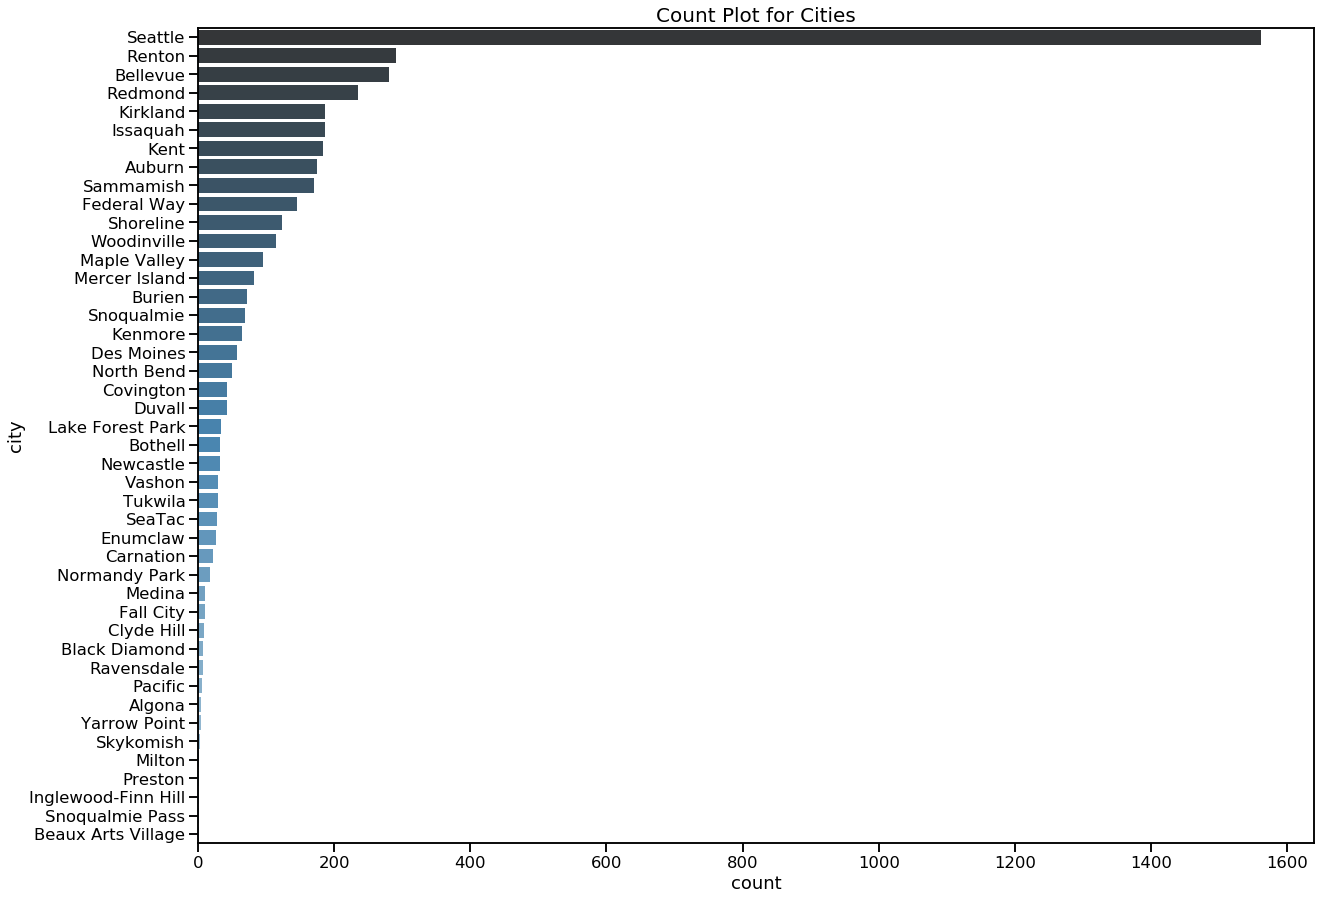

In [381]:
# count plot is similar to univariate distributions
plt.figure(figsize=(20,15))
sns.countplot(y='city',data=df, palette="Blues_d", order=df['city'].value_counts().keys())
plt.title('Count Plot for Cities', size=20)
plt.show()

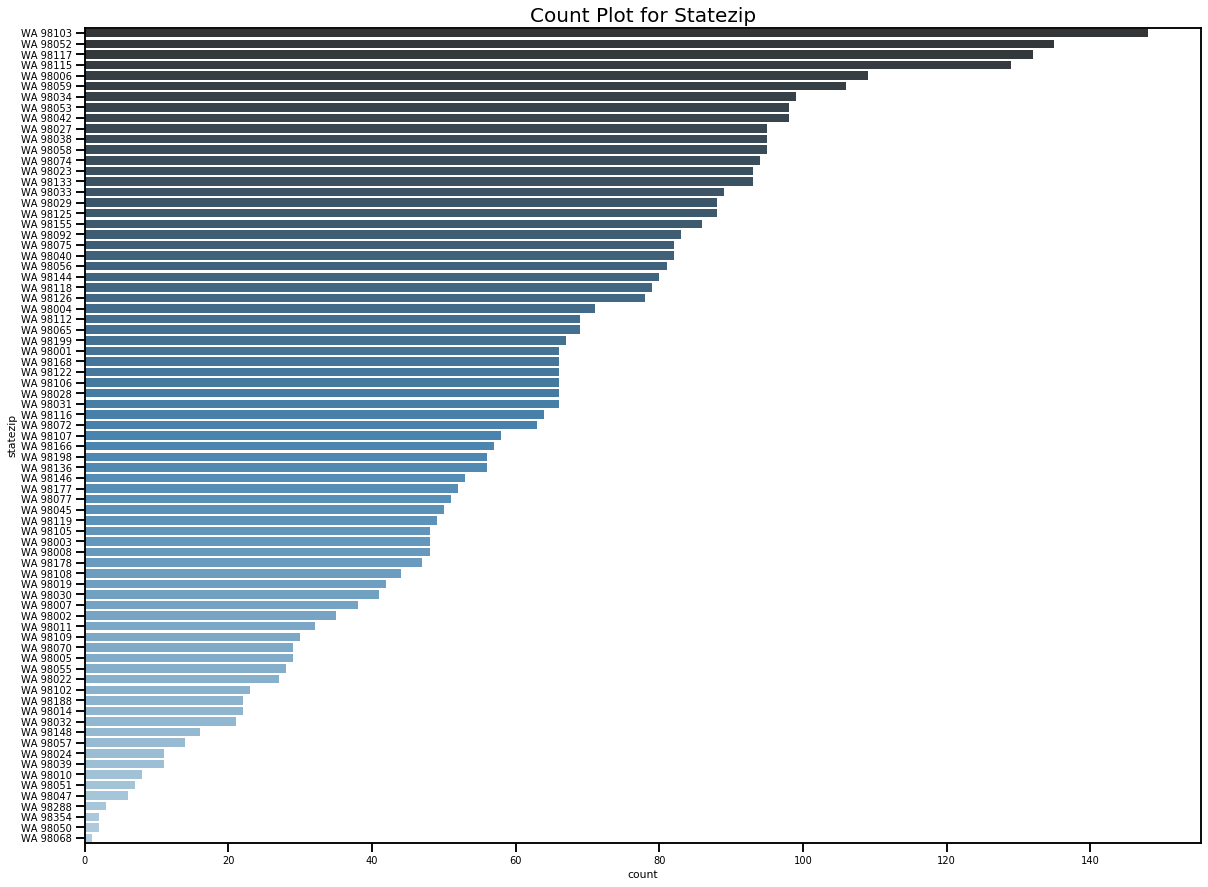

In [383]:
sns.set_context('talk', font_scale=0.6)
plt.figure(figsize=(20,15))
sns.countplot(y='statezip',data=df, palette="Blues_d", order=df['statezip'].value_counts().keys())
plt.title('Count Plot for Statezip', size=20)
plt.show()

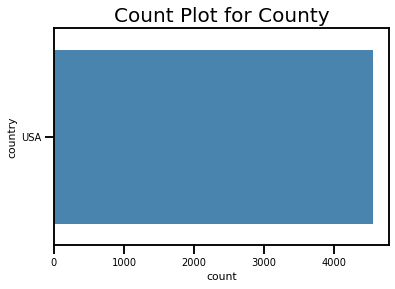

In [353]:
sns.countplot(y='country',data=df, palette="Blues_d")
plt.title('Count Plot for County', size=20)
plt.show()

### Relationship b/w categorical feature and output (prices)

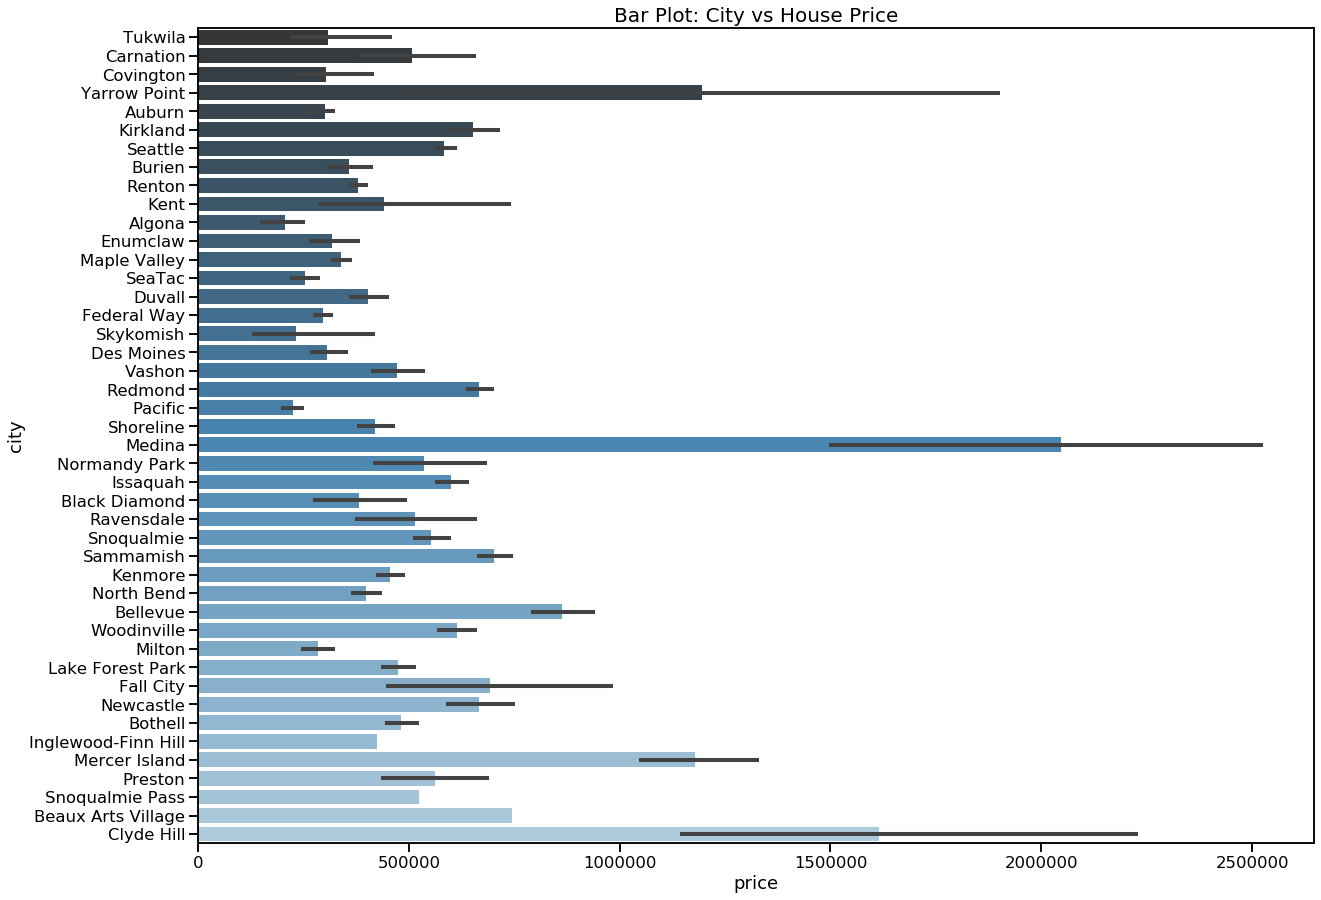

In [354]:
sns.set_context('talk')
plt.figure(figsize=(20,15))
sns.barplot(y='city',x='price',data=df, palette="Blues_d", order = df.sort_values('price', ascending=True).city.unique())
plt.title('Bar Plot: City vs House Price', size=20)
plt.show()

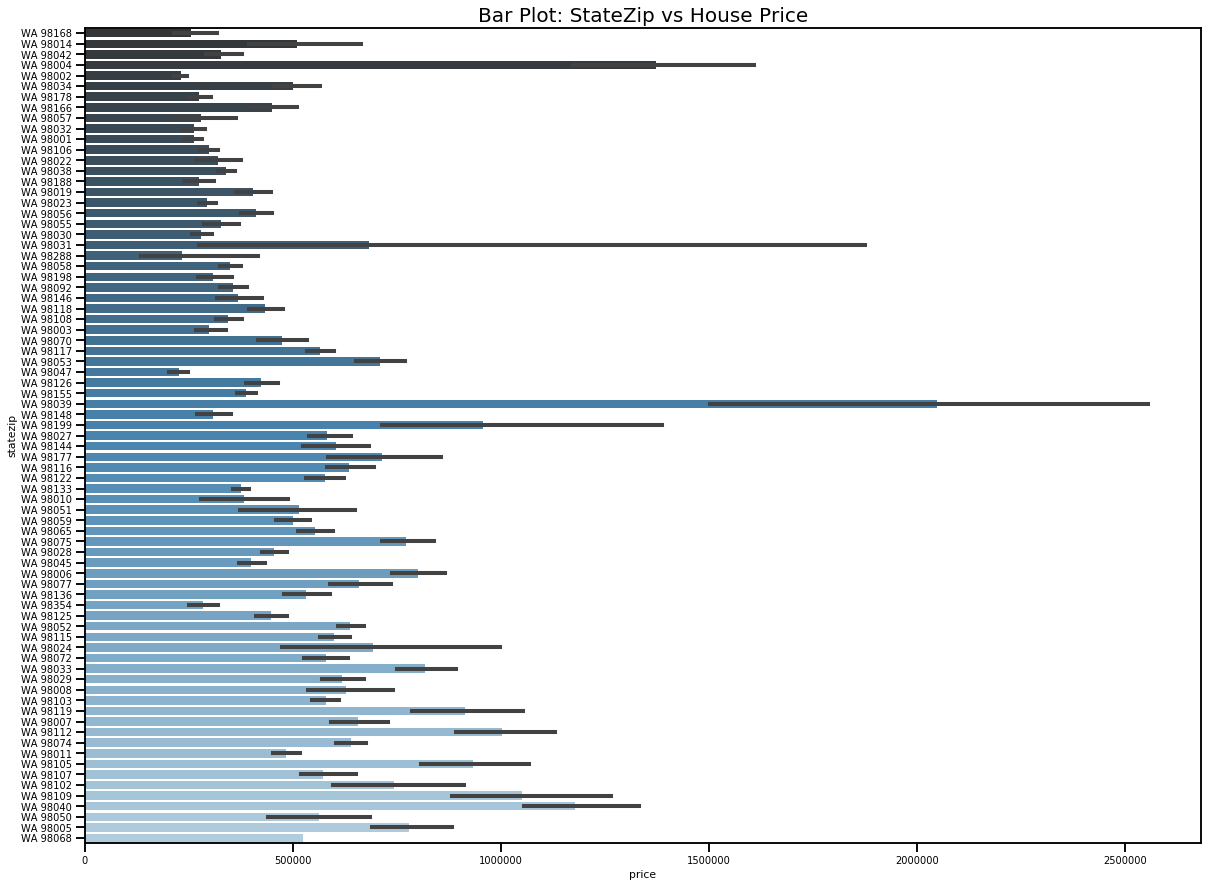

In [356]:
sns.set_context('talk', font_scale=0.6)
plt.figure(figsize=(20,15))
sns.barplot(y='statezip',x='price',data=df, palette="Blues_d", order = df.sort_values('price', ascending=True).statezip.unique())
plt.title('Bar Plot: StateZip vs House Price', size=20)
plt.show()

### Comments
Since country has only single value so it has no significant information. Count plots show that a lot of data is calculated from Seattle, Renton and Bellevue. Moreover, box plots show that cities like medina, clyde hill and yellow point and zip codes of WA 98004, WA 98039 and WA 98199 have most costly houses.

## Visualizing Continuous Variables

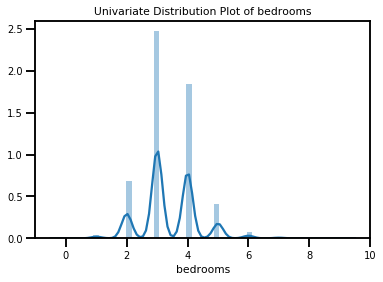

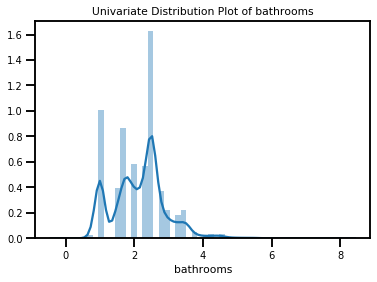

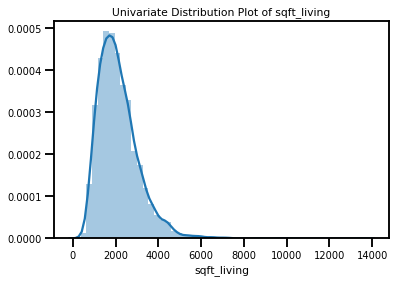

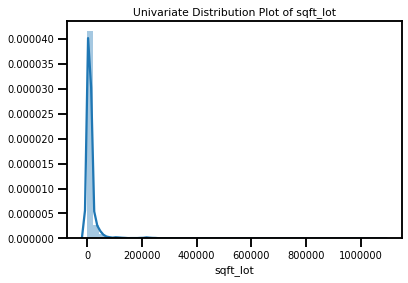

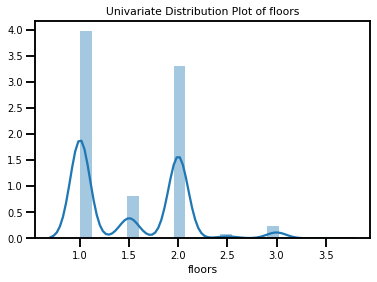

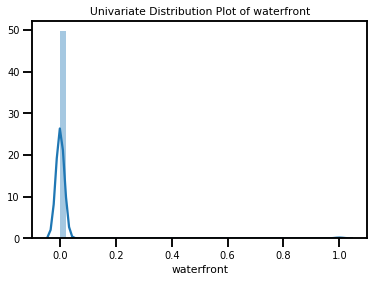

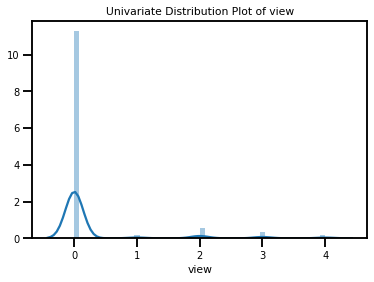

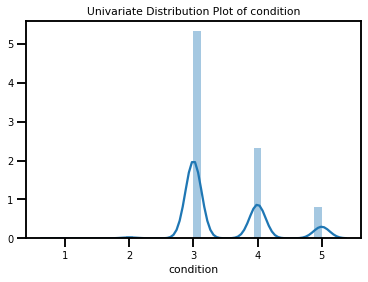

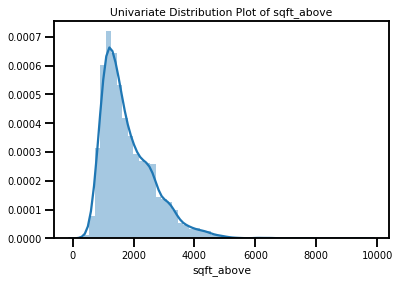

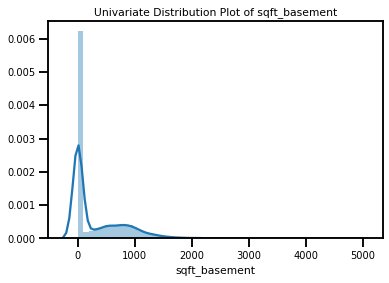

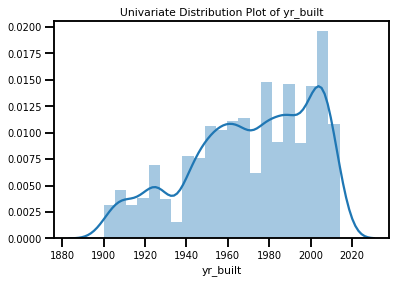

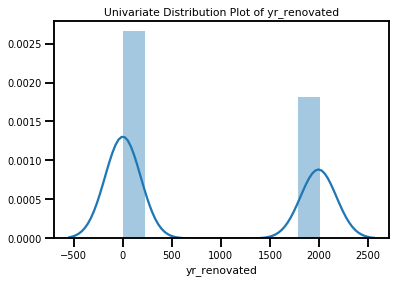

In [384]:
# univariate distributions
for i in continuous_features:
    sns.distplot(df_data[i])
    plt.title('Univariate Distribution Plot of ' + str(i))
    plt.pause(0.01)

## Comments 
Some of the univariate distribution plots are quite interesting. For example bathrooms, floors have values in points like 1.5, 2.5. Moreover, the peak at zero for yr_renovated actually shows that no renovation was done

### Scatter Plots to visualize relationship between continuous variables and Prices

In [ ]:
sns.distributions._has_statsmodels = False # to use scipy instead of statsmodels(giving error) for kde estimation

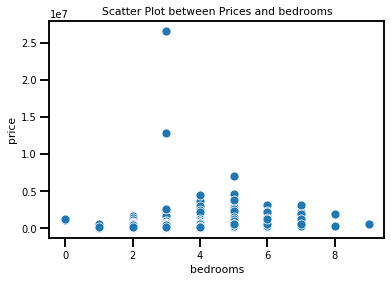

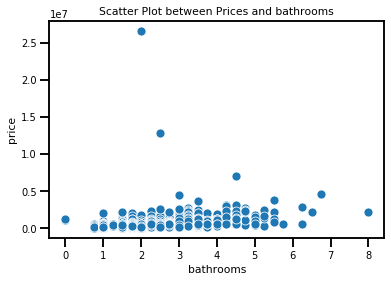

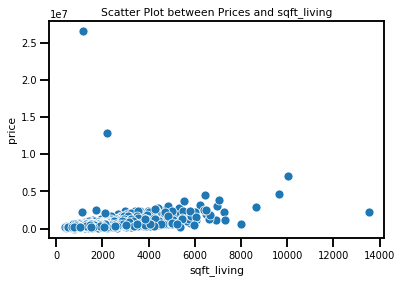

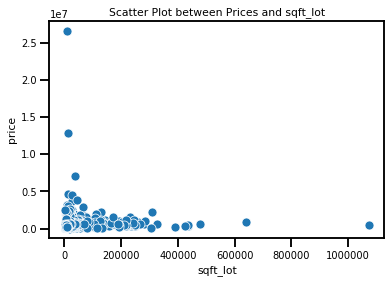

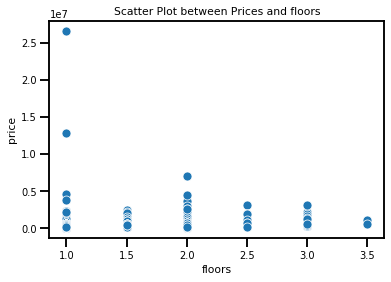

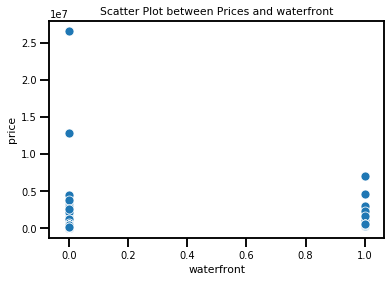

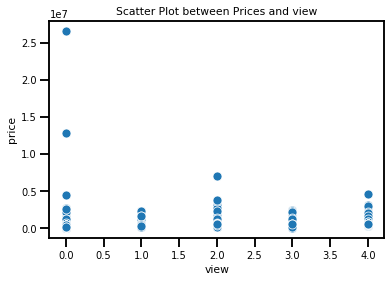

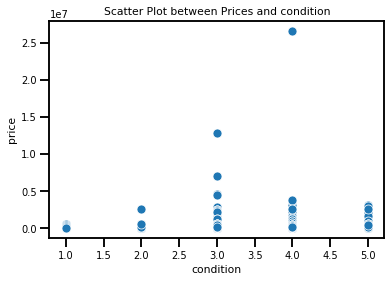

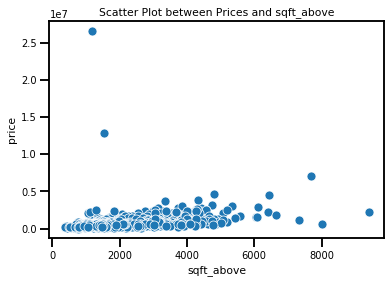

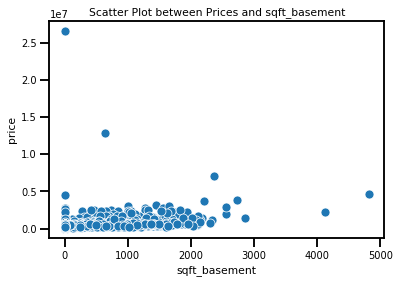

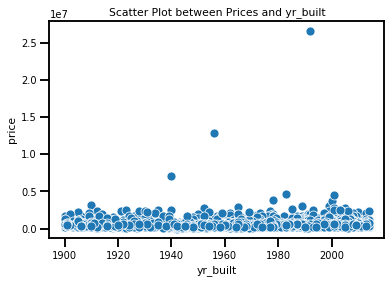

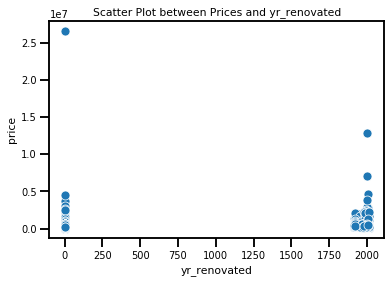

In [163]:
for i in continuous_features:
    sns.scatterplot(y=df_targets, x=df_data[i])
    plt.title('Scatter Plot between Prices and ' + str(i))
    plt.pause(0.01)

## Visualizing Distribution of Targets

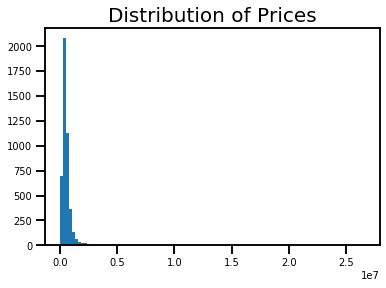

In [385]:
plt.hist(df_targets, bins=100)
plt.title('Distribution of Prices', size=20)
plt.show()

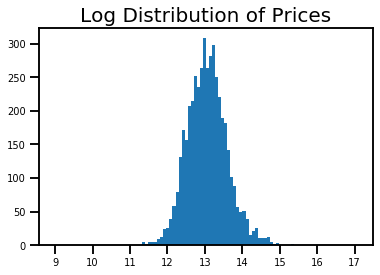

In [386]:
plt.hist(np.log(df_targets), bins=100)
plt.title('Log Distribution of Prices', size=20)
plt.show()

### Comment 
Taking log reduces the skew in data. So, it would be easy to predict targets in non-skewed tranformation. So, we can just use this for fitting and at the end take inverse (i.e. exponential) to get back original data. However, later we found that the results of regression analysis didn't improve by incorporating this tranformation and so we just used original labels

### 2.4 Split data in training and test set. Do not use the test-set unless for a final evaluation in 2.5. Use ColumnTransformer and pipeline to encode categorical variables (your choice of OneHotEncoder or another one from the categorical_encoder package, or both). Impute missing values using SimpleImputer. Evaluate Linear Regression (OLS), Ridge, Lasso and ElasticNet using cross-validation with the default parameters. Does scaling the data (within the pipeline) with StandardScaler help? Use the preprocessing that works best going forward.

In [391]:
df = df_targets_handled.copy()
df_data, df_targets = df[df.keys().drop('price')], df['price']
all_features = df_data.keys()
cat_indxs = np.where(df_data.dtypes==object)
categorical_features = list(df_data.keys()[cat_indxs])
continuous_features = [x for x in all_features if x not in categorical_features]
print('categorical features: ', categorical_features)

categorical features:  ['city', 'statezip', 'country']


In [392]:
# preprocessings options (overall 4 possible combinations)
# assuming object datatype is representative of categorical data

# later we have to combine preprocessing and estimator in a single pipeline to be passed
# to GridSearchCV as a metaestimator, and for that we have to pass category names as an
# argument to ordinal/categorical encoders to avoid runtime error while fitting gridsearch.

cats = [] # variable to store names of categories of each categorical column in dataset
for i in categorical_features:
    cats.append(df_data[i].unique()) 
    
preprocessing_onehot = make_column_transformer(
    ((OneHotEncoder(categories=cats, drop='first')), make_column_selector(dtype_include=object)), # may have passed categorical_features as argument
    remainder='passthrough')

preprocessing_ordinal = make_column_transformer(
    (OrdinalEncoder(categories=cats), make_column_selector(dtype_include=object)), 
    remainder='passthrough')

preprocessing_onehot_cont = make_column_transformer(
    ((OneHotEncoder(categories=cats, drop='first')), make_column_selector(dtype_include=object)), 
    remainder=StandardScaler())

preprocessing_ordinal_cont = make_column_transformer(
    (OrdinalEncoder(categories=cats), make_column_selector(dtype_include=object)), 
    remainder=StandardScaler())

In [393]:
# use here for checking the shape of the output for all 4, then rename left side to avoid calling df_original again and again
# have to use .toarray() for onehotencoded ones
preprocess = preprocessing_onehot_cont
df_data1 = pd.DataFrame(preprocess.fit_transform(df_data).toarray())
x_trainval, x_test, y_trainval, y_test = train_test_split(df_data1, df_targets, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval)
print('train set:  features: ', x_train.shape, 'labels: ', y_train.shape)
print('valid set:  features: ', x_val.shape,   'labels: ', y_val.shape)
print('Test  set:  features: ', x_test.shape,  'labels: ', y_test.shape)

train set:  features:  (2559, 131) labels:  (2559,)
valid set:  features:  (854, 131) labels:  (854,)
Test  set:  features:  (1138, 131) labels:  (1138,)


### Ordinal Encoding

In [394]:
import warnings
warnings.filterwarnings('default')
warnings.filterwarnings('ignore', category=sklearn.exceptions.ConvergenceWarning)

In [399]:
cv = 10 # large value to get stable results (low variance)

In [400]:
preprocess = preprocessing_ordinal
x_train, x_test, y_train, y_test = train_test_split(df_data, df_targets)

print('########## R-squared Score Comparison ############')
print('###### With Only Ordinal Encoding ########')
print('Linear Regression: ', np.mean(cross_val_score(make_pipeline(preprocess, LinearRegression()), x_train, y_train, cv=cv)))
print('Ridge  Regression: ', np.mean(cross_val_score(make_pipeline(preprocess, Ridge()), x_train, y_train, cv=cv)))
print('Lasso  Regression: ', np.mean(cross_val_score(make_pipeline(preprocess, Lasso()), x_train, y_train, cv=cv)))
print('E-Net  Regression: ', np.mean(cross_val_score(make_pipeline(preprocess, ElasticNet()), x_train, y_train, cv=cv)))

########## R-squared Score Comparison ############
###### With Only Ordinal Encoding ########
Linear Regression:  0.5236850599164773
Ridge  Regression:  0.524000698776028
Lasso  Regression:  0.5236864761996367
E-Net  Regression:  0.5124999922480907


In [402]:
preprocess = preprocessing_ordinal_cont
x_train, x_test, y_train, y_test = train_test_split(df_data, df_targets)

print('########## R-squared Score Comparison ############')
print('###### With Ordinal + Continuous Encoding ########')

print('Linear Regression: ', np.mean(cross_val_score(make_pipeline(preprocess, LinearRegression()), x_train, y_train, cv=cv)))
print('Ridge  Regression: ', np.mean(cross_val_score(make_pipeline(preprocess, Ridge()), x_train, y_train, cv=cv)))
print('Lasso  Regression: ', np.mean(cross_val_score(make_pipeline(preprocess, Lasso()), x_train, y_train, cv=cv)))
print('E-Net  Regression: ', np.mean(cross_val_score(make_pipeline(preprocess, ElasticNet()), x_train, y_train, cv=cv)))

########## R-squared Score Comparison ############
###### With Ordinal + Continuous Encoding ########
Linear Regression:  0.46908115732926225
Ridge  Regression:  0.4690896469721103
Lasso  Regression:  0.469081879420839
E-Net  Regression:  0.44639538989771166


### With onehot encoding

In [404]:
# using large cv was slow especially for onehot encoding
preprocess = preprocessing_onehot
x_train, x_test, y_train, y_test = train_test_split(df_data, df_targets)

print('########## R-squared Score Comparison ############')
print('###### With Only Onehot Encoding ########')

print('Linear Regression: ', np.mean(cross_val_score(make_pipeline(preprocess, LinearRegression()), x_train, y_train, cv=cv)))
print('Ridge  Regression: ', np.mean(cross_val_score(make_pipeline(preprocess, Ridge()), x_train, y_train, cv=cv)))
print('Lasso  Regression: ', np.mean(cross_val_score(make_pipeline(preprocess, Lasso()), x_train, y_train, cv=cv)))
print('E-Net  Regression: ', np.mean(cross_val_score(make_pipeline(preprocess, ElasticNet()), x_train, y_train, cv=cv)))

########## R-squared Score Comparison ############
###### With Only Onehot Encoding ########
Linear Regression:  0.5657326031479336
Ridge  Regression:  0.41495946823084695
Lasso  Regression:  0.5643450178887152
E-Net  Regression:  0.46281114626091596


In [405]:
preprocess = preprocessing_onehot_cont
x_train, x_test, y_train, y_test = train_test_split(df_data, df_targets)

print('########## R-squared Score Comparison ############')
print('###### With Onehot + Continuous Encoding ########')

print('Linear Regression: ', np.mean(cross_val_score(make_pipeline(preprocess, LinearRegression()), x_train, y_train, cv=cv)))
print('Ridge  Regression: ', np.mean(cross_val_score(make_pipeline(preprocess, Ridge()), x_train, y_train, cv=cv)))
print('Lasso  Regression: ', np.mean(cross_val_score(make_pipeline(preprocess, Lasso()), x_train, y_train, cv=cv)))
print('E-Net  Regression: ', np.mean(cross_val_score(make_pipeline(preprocess, ElasticNet()), x_train, y_train, cv=cv)))

########## R-squared Score Comparison ############
###### With Onehot + Continuous Encoding ########
Linear Regression:  0.6921069024743802
Ridge  Regression:  0.6944645877486476
Lasso  Regression:  0.6921548641635888
E-Net  Regression:  0.5140602084107803


### Comment 
a very interesting observation that for different splits of validation set, results vary largely for both ordinal and categorical encoding. However using cross validation and setting cv to a higher value of 10 made situation a bit stable and it was easy to see that onehotencoder was performing better than ordinal.

Moreover, in terms of feature scaling, there doesn't seem to be a big change in results (moreover since results aren't consistent for each fold so we can't simply compare). However, doing some online search suggests both would lead to same solution then why not try it.

I would go with onehotencoder+continuous

### 2.5 Tune the parameters of the models using GridSearchCV. Do the results improve? Visualize the dependence of the validation score on the parameters for Ridge, Lasso and ElasticNet.

In [416]:
preprocess = preprocessing_onehot_cont
x_train, x_test, y_train, y_test = train_test_split(df_data, df_targets, random_state=0)
print('train set:  features: ', x_train.shape, 'labels: ', y_train.shape)
print('Test  set:  features: ', x_test.shape,  'labels: ', y_test.shape)

train set:  features:  (3413, 15) labels:  (3413,)
Test  set:  features:  (1138, 15) labels:  (1138,)


In [417]:
# ols linear regression have no hyperparameters
param_grid_lin_reg = {}
grid_lin_reg = GridSearchCV(make_pipeline(preprocess, LinearRegression()), param_grid=param_grid_lin_reg,
                           cv = RepeatedKFold(10, 5))
grid_lin_reg.fit(x_train, y_train) 
print('Maximum Cross Validation R-2 Score: ',  round(grid_lin_reg.best_score_,4))
print('Optimal Parameters: ', grid_lin_reg.best_params_)

Maximum Cross Validation R-2 Score:  0.6453
Optimal Parameters:  {}


In [418]:
# Ridge Regression
param_grid_ridge = {'ridge__alpha': np.logspace(-4,4,20)}
grid_ridge = GridSearchCV(make_pipeline(preprocess, Ridge()), param_grid=param_grid_ridge, cv = RepeatedKFold(5, 2))
grid_ridge.fit(x_train, y_train) 
print('Maximum Cross Validation R-2 Score: ',  round(grid_ridge.best_score_,4))
print('Optimal Parameters: ', grid_ridge.best_params_)

Maximum Cross Validation R-2 Score:  0.5885
Optimal Parameters:  {'ridge__alpha': 4.281332398719396}


In [419]:
# Lasso Regression, takes a lot of time so reduced alpha's combinations and kfolds
param_grid_lasso = {'lasso__alpha': np.logspace(-3,3,8)}
grid_lasso = GridSearchCV(make_pipeline(preprocess, Lasso()), param_grid=param_grid_lasso, cv = 5)
grid_lasso.fit(x_train, y_train) 
print('Maximum Cross Validation R-2 Score: ',  round(grid_lasso.best_score_,4))
print('Optimal Parameters: ', grid_lasso.best_params_)

Maximum Cross Validation R-2 Score:  0.5657
Optimal Parameters:  {'lasso__alpha': 138.9495494373136}


In [420]:
# ElasticNet, takes a lot of time so reduced alpha's combinations and cv's
param_grid_enet = {'elasticnet__alpha': np.logspace(-3,3,8), 'elasticnet__l1_ratio': np.arange(0, 1.05, 0.2)}
grid_enet = GridSearchCV(make_pipeline(preprocess, ElasticNet()), param_grid=param_grid_enet, cv = 5)
grid_enet.fit(x_train, y_train) 
print('Maximum Cross Validation R-2 Score: ',  round(grid_enet.best_score_,4))
print('Optimal Parameters: ', grid_enet.best_params_)

Maximum Cross Validation R-2 Score:  0.571
Optimal Parameters:  {'elasticnet__alpha': 0.0071968567300115215, 'elasticnet__l1_ratio': 0.6000000000000001}


In [424]:
print('R-2 Score of the Optimal Model: ', grid_lin_reg.score(x_test, y_test))

R-2 Score of the Optimal Model:  0.7316475433104207


### Comment
Surprisingly Linear Regression performed better than other algos in terms of R-2 score and gave maximum cross validation score of 0.643 and test set score of 0.73 that is a good score.

Moreover, using a different random_state value would result in different splitting thus leading to different results

### Using log-tranformed versions
unexpectedly didn't improve the results so avoided it

In [433]:
log_ridge = TransformedTargetRegressor(Ridge(), func=np.log, inverse_func=np.exp)
print(np.mean(cross_val_score((make_pipeline(preprocess, log_ridge)),x_train, y_train, cv=10)))
print(np.mean(cross_val_score((make_pipeline(preprocess, Ridge())),x_train, y_train, cv=10)))

-0.2677073937245785
0.586951063011593


In [445]:
log_lasso = TransformedTargetRegressor(Lasso(), func=np.log, inverse_func=np.exp)
print(np.mean(cross_val_score((make_pipeline(preprocess, log_lasso)),x_train, y_train, cv=10)))
print(np.mean(cross_val_score((make_pipeline(preprocess, Lasso())),x_train, y_train, cv=10)))

-0.040552959229761674
0.583150159598787


In [443]:
log_linreg = TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp)
grid_linreg_log = GridSearchCV(make_pipeline(preprocess, log_linreg), param_grid=param_grid_lin_reg, 
                               cv = RepeatedKFold(5, 3))
grid_linreg_log.fit(x_train, y_train) 
print('Maximum Cross Validation R-2 Score: ',  round(grid_linreg_log.best_score_,4))
print('Optimal Parameters: ', grid_linreg_log.best_params_)

Maximum Cross Validation R-2 Score:  -0.1359
Optimal Parameters:  {}


### Visualizing the cross validation scores as function of hyperparameters

In [453]:
sns.set_context('talk', font_scale=0.8)

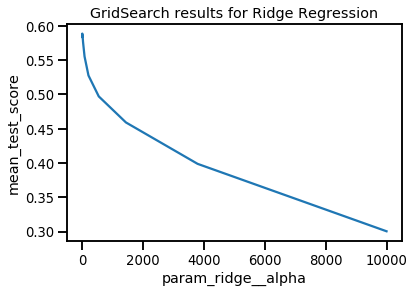

In [454]:
df_ridge = pd.DataFrame(grid_ridge.cv_results_)
sns.lineplot(x=df_ridge.param_ridge__alpha, y=df_ridge.mean_test_score)
plt.title('GridSearch results for Ridge Regression')
plt.show()

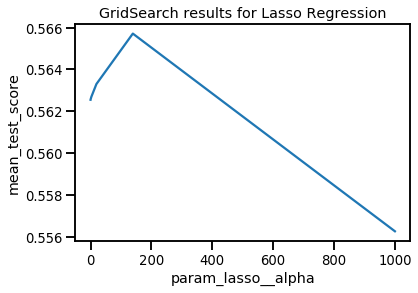

In [455]:
df_lasso = pd.DataFrame(grid_lasso.cv_results_)
sns.lineplot(x=df_lasso.param_lasso__alpha, y=df_lasso.mean_test_score)
plt.title('GridSearch results for Lasso Regression')
plt.show()

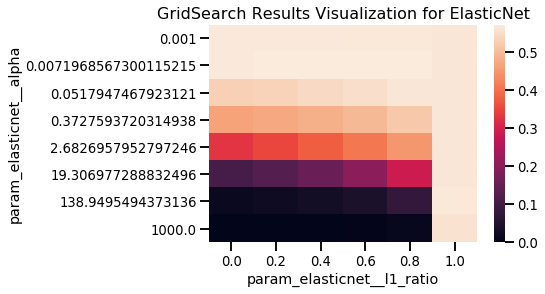

In [456]:
pt_enet = pd.pivot_table(pd.DataFrame(grid_enet.cv_results_),values='mean_test_score', 
               index='param_elasticnet__alpha', columns='param_elasticnet__l1_ratio')
pt_enet.columns = np.round(np.arange(0,1.01,0.2), 3) # to round off
sns.heatmap(pt_enet)
plt.title('GridSearch Results Visualization for ElasticNet', size=16)
plt.xlabel('param_elasticnet__l1_ratio')
plt.show()

### 2.6 Visualize the 20 most important coefficients of the resulting models. Do they agree on which features are important?

In [458]:
def coeff_visualizer(estimator, transformed_feature_names, plot_title='Model Coefficients Visualization', num_of_coeff=20, figsize=(20,10)):
        coeff = abs(np.ravel(estimator.coef_))
        num_of_coeff = num_of_coeff
        sort_indices = np.argsort(coeff) # return indices that would sort an array
        less_imp_coeff = max(sort_indices)-num_of_coeff
        b = sort_indices > less_imp_coeff
        transformed_features = transformed_feature_names

        imp_coeff = []
        imp_features = []
        for i,j in enumerate(b):
            if j==True:
                imp_coeff.append(coeff[i])
                imp_features.append(transformed_features[i])

        a = zip(imp_coeff, imp_features)
        df_imp_coeff = pd.DataFrame(a, columns=['imp_coeff', 'feature_names'])
        df_imp_coeff = df_imp_coeff.sort_values('imp_coeff', ascending=False)
    
        plt.figure(figsize=figsize)
        sns.barplot(x=df_imp_coeff['imp_coeff'], y=df_imp_coeff['feature_names'], data=df_imp_coeff,  palette="Blues_d")
        plt.title(plot_title, size=20)
        plt.show()

In [459]:
onehot_categorical_features = list(preprocess.named_transformers_['onehotencoder'].get_feature_names(categorical_features))

In [460]:
pd.DataFrame(preprocess.fit_transform(x_train).toarray(), columns = onehot_categorical_features+continuous_features).head()

,city_Seattle,city_Kent,city_Bellevue,city_Redmond,city_Maple Valley,city_North Bend,city_Lake Forest Park,city_Sammamish,city_Auburn,city_Des Moines,...,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.392679,-0.212339,-0.949307,-0.085901,-0.317010,-0.671439,-1.215447,-0.660367,-0.536083,1.207040
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.232140,-0.195953,0.902113,-0.085901,-0.317010,-0.671439,0.102108,-0.660367,0.643359,1.232593
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.604286,-0.111544,-0.949307,-0.085901,-0.317010,0.814697,-0.325207,1.826299,-0.300195,-0.820813
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.203949,0.133657,0.902113,-0.085901,-0.317010,-0.671439,2.867788,-0.660367,0.879248,-0.820813
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.158952,0.205989,-0.949307,11.641306,4.727074,-0.671439,-0.847481,1.204632,-1.142654,1.221350


In [463]:
sns.set_context('talk') # ppt model

In [464]:
transformed_features_names = onehot_categorical_features + continuous_features

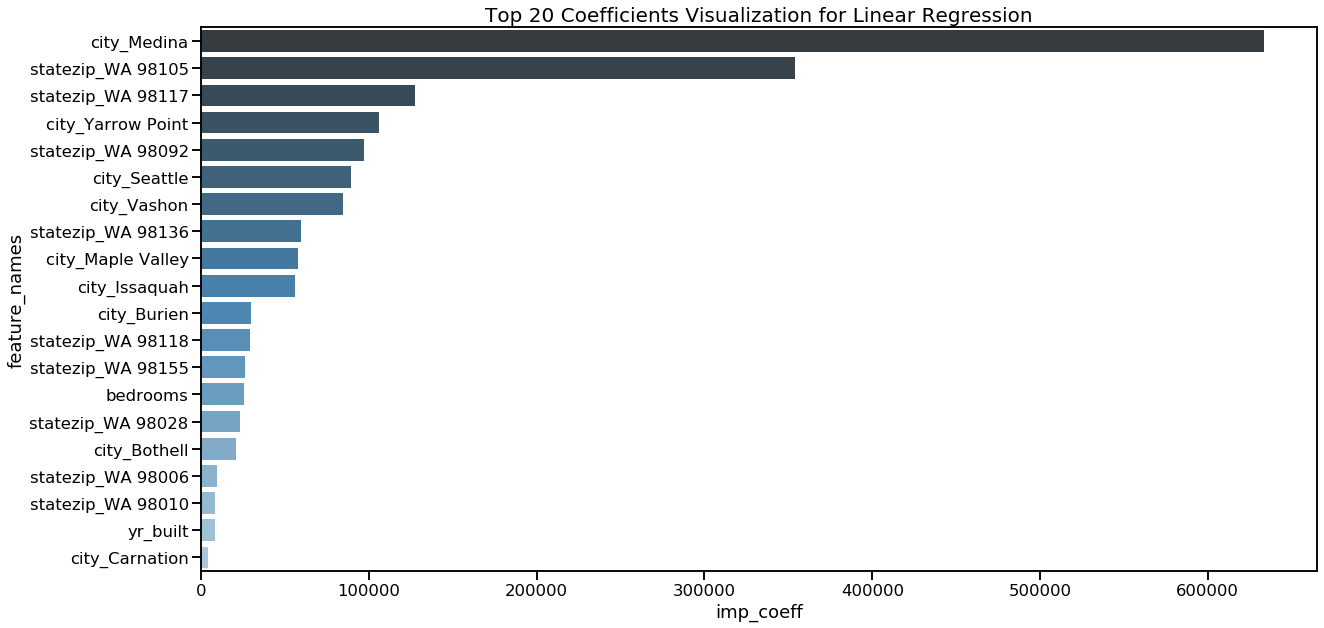

In [470]:
coeff_visualizer(grid_lin_reg.best_estimator_.steps[1][1], transformed_features_names, 
                 plot_title='Top 20 Coefficients Visualization for Linear Regression')

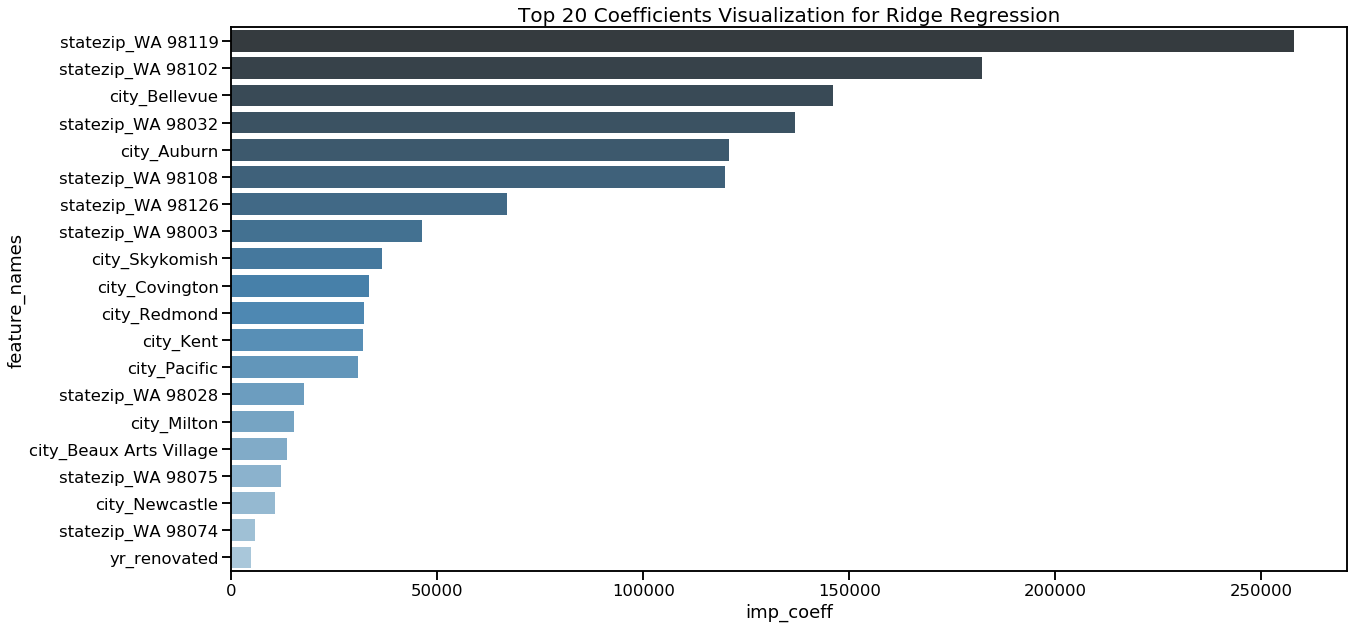

In [471]:
coeff_visualizer(grid_ridge.best_estimator_.steps[1][1], transformed_features_names,
                plot_title='Top 20 Coefficients Visualization for Ridge Regression')

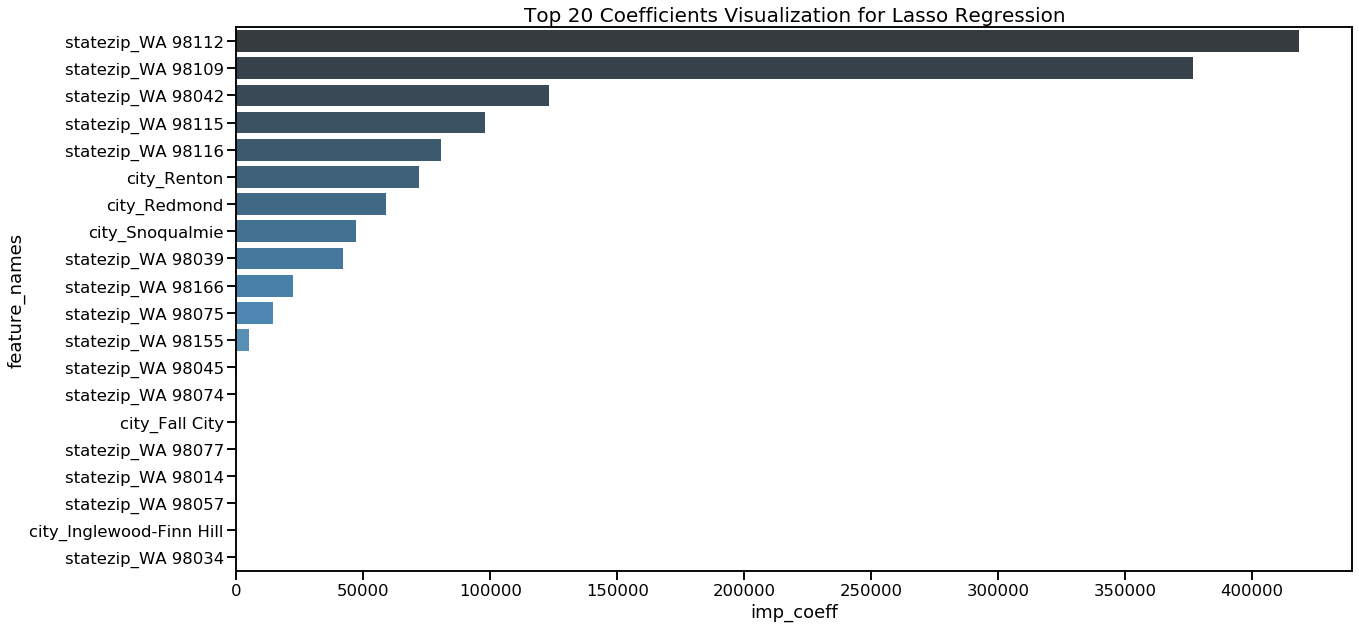

In [472]:
coeff_visualizer(grid_lasso.best_estimator_.steps[1][1], transformed_features_names,
                plot_title='Top 20 Coefficients Visualization for Lasso Regression')

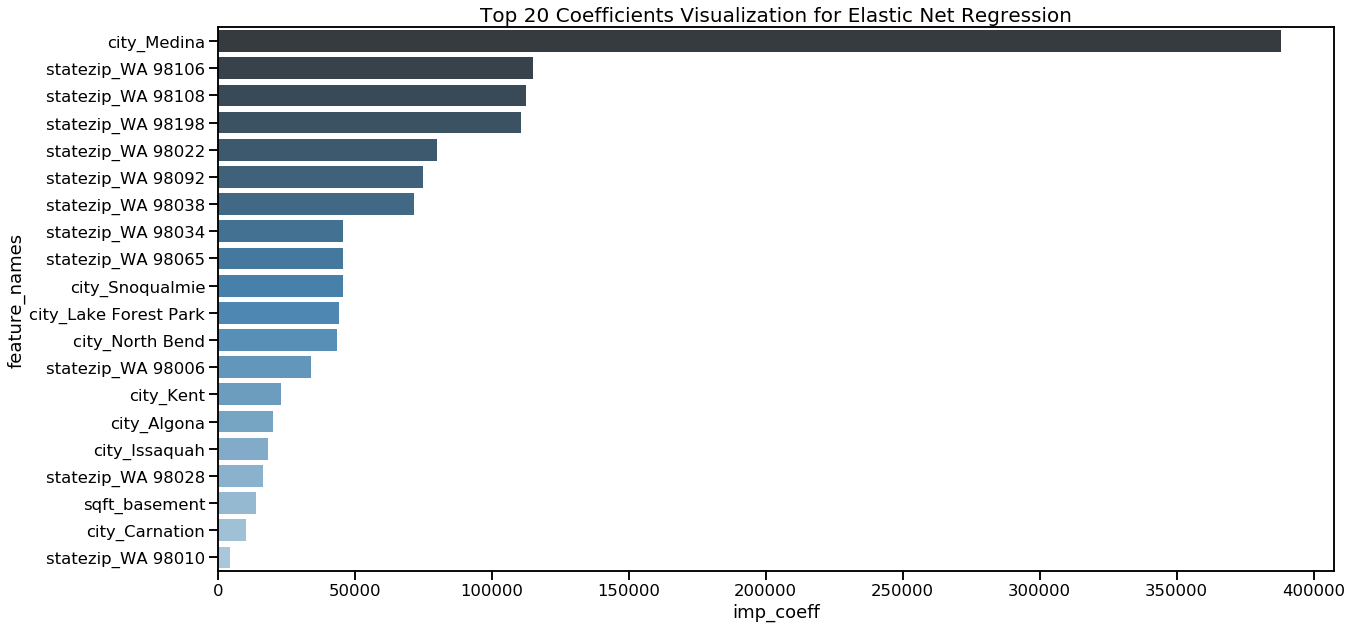

In [473]:
coeff_visualizer(grid_enet.best_estimator_.steps[1][1], transformed_features_names,
                plot_title='Top 20 Coefficients Visualization for Elastic Net Regression')

###  Comment
A very interesting observation that different regression algorithms are giving different weightage to different features and only a few features are common among all of them. Moreover, use of l1 penalty in lasso introduced sparsity as compared to ridge regression and for elastic net value of l1_ratio paramter is 0.6 so that is inbetween both ridge and lasso and count of non-significant coefficients of elastic net of these two algorithms is inbetween these two algorithms as expected

## Conclusion
In this exercise, we compared the performance of 4 different linear regression algorithms to predict house prices in sydney housing dataset. We first of all imported the dataset and utilized pandas's datahandling capabilities to find the missing values in the dataset and found that this time they were encoded as '0' price. We removed them from the dataset and then separated the categorical and continuous features in the dataset. Then for categorical features, we used countplot() and boxplot() and for continuous features, we used barplot() and scatter() plot for EDA (Exploratory Data Analysis). Then we performed encoding of categorical features and among different encoding schemes, one hot encoding worked best with StandardScaler encoding for continuous features. Then we performed GridSearch and found linearRegression(OLS) performed best. Then, we tried to do targetTransformation by following the observation that targets were skewed and taking log would reduce the skewness in the dataset but we found that results bacame worse so we dropped this idea. At the end, we visualized the top 20 coefficients for all these algorithms and found that different algorithms are using different feature weights for making prediction.